Đề tài 9. Dựa vào tập dữ liệu ảnh chữ số viết tay (đã được giáo viên cung cấp trong phần thực hành) đặt trong các thư mục
theo cấu trúc tương tự như trong bài thực hành đã có.

1)  Thực hiện việc rút gọn số chiều dữ liệu, sau đó tham khảo để hiển thị trực quan các phân lớp dữ liệu dạng 3D hoặc
2D.

2.1) Thực hiện phân cụm (clustering) dữ liệu gốc bằng 01 thuật toán phân cụm. Hiển thị trực quan và đánh dấu các cụm.

3) Multinomial Logistic Regression để phân loại đa lớp

4) Xây dựng chương trình sử dụng mô hình CNN để phân loại các hình ảnh. Kiến trúc cụ thể như sau: Mạng gồm ít
nhất 03 tầng tích chập hỗn hợp Convolution + Activation ReLU + Max Pooling, 02 tầng fully connected với số units
phù hợp và tầng quyết định cuối cùng sử dụng softmax.  Huấn luyện mô hình bằng tập dữ liệu training sau đó chạy
kiểm tra với dữ liệu trong tập validation.

5) Xây dựng chương trình sử dụng mô hình Multi-classes support vector machine

2.2) Sử dụng thuật toán phân cụm EM(thuật toán phân cụm thứ 2)

6) So sánh độ chính xác (sử dụng accuracy, confusion matrix, recall và precision) của các mô hình trong ý 3,4,5.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

ĐỌC DỮ LIỆU VÀ KIỂM TRA DỮ LIỆU

Cần cho 4 tệp train-images-idx3-ubyte.gz, train-labels-idx1-ubyte.gz, t10k-images-idx3-ubyte.gz, t10k-labels-idx1-ubyte.gz vào một thư mục handwritting

In [15]:
# Đường dẫn đến tập dữ liệu
data_path = r'/content/handwriting'
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [16]:
# Hàm đọc dữ liệu từ tập tin .gz
def read_mnist(images_path, labels_path):
    import gzip

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28, 1)

    return images, labels

In [17]:
# Đọc dữ liệu huấn luyện và kiểm tra
train_images, train_labels = read_mnist(train_images_path, train_labels_path)
test_images, test_labels = read_mnist(test_images_path, test_labels_path)

In [18]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


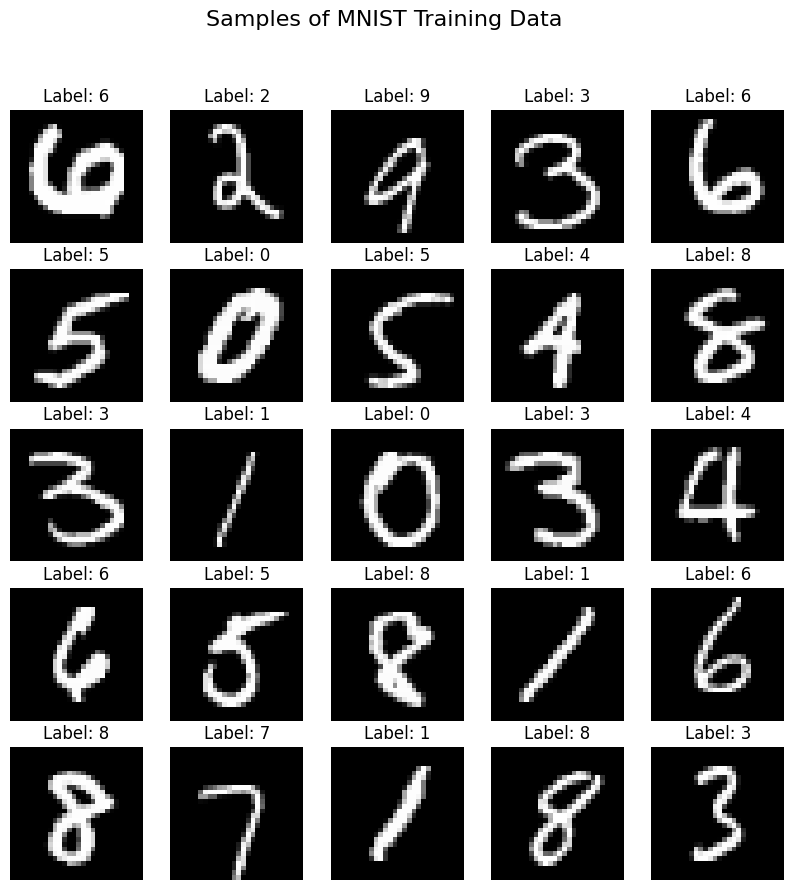

In [19]:
# Chọn một số mẫu ngẫu nhiên từ tập dữ liệu huấn luyện để hiển thị
num_samples = 25
random_indices = np.random.choice(train_images.shape[0], num_samples, replace=False)
sample_images = train_images[random_indices]

# Hiển thị các mẫu ảnh trong lưới
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(sample_images[i][:, :, 0], cmap='gray')
    plt.title(f"Label: {train_labels[random_indices[i]]}")
    plt.axis('off')
plt.suptitle('Samples of MNIST Training Data', fontsize=16)
plt.show()

----------------------------------------------------------------------------------------------------

Ý 1: GIẢM CHIỀU PCA

**Xây dựng theo các bước thực hiện PCA.**

Explained Variance (Eig): [0.05646717 0.04078272 0.0373938  0.02885115 0.02521109 0.0219427
 0.01923344 0.01745799 0.01535092 0.0140172 ]
Explained Variance (SVD): [0.05646717 0.04078272 0.0373938  0.02885115 0.02521109 0.0219427
 0.01923344 0.01745799 0.01535092 0.0140172 ]
train_images_reduced Shape: (60000, 2)
train_images shape: (60000, 28, 28, 1)


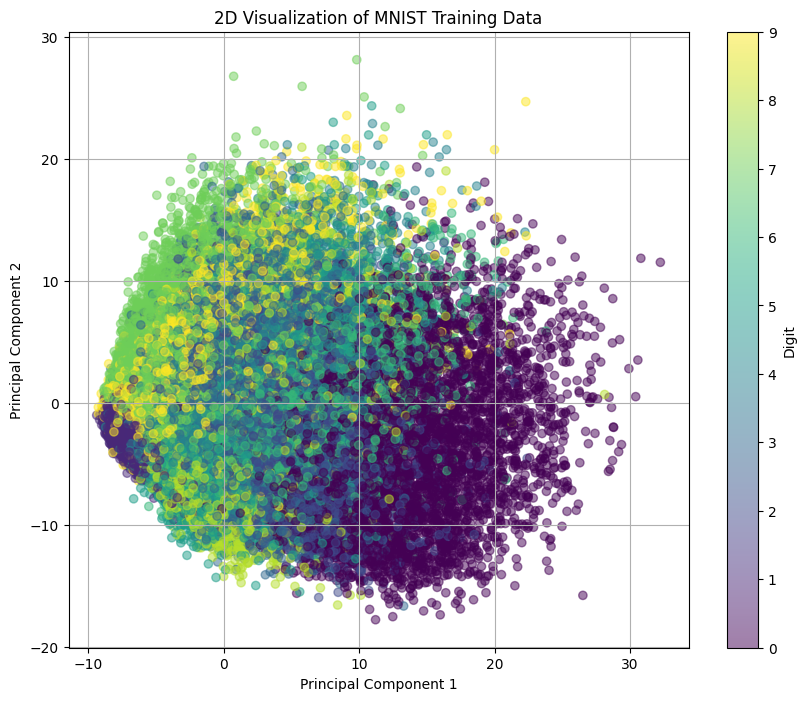

In [20]:
# Chuẩn hóa dữ liệu
train_images_flat = train_images.reshape(train_images.shape[0], -1)  # Reshape to (60000, 784)
mean = np.mean(train_images_flat, axis=0)
std = np.std(train_images_flat, axis=0)
std[std == 0] = 1  # Tránh chia cho zero
train_images_normalized = (train_images_flat - mean) / std

# Tính ma trận hiệp phương sai
cov_matrix = np.cov(train_images_normalized, rowvar=False)

# Phân tích hệ giá trị-vector riêng bằng cách sử dụng eigh vì ma trận là đối xứng
eigen_values_eigh, eigen_vectors_eigh = np.linalg.eigh(cov_matrix)
# Sử dụng SVD để phân tích
u, s, vh = np.linalg.svd(cov_matrix)
eigen_values_svd = s
eigen_vectors_svd = u

# Hiển thị mức độ “quan trọng” của các giá trị riêng
explained_variance_eigh = eigen_values_eigh / np.sum(eigen_values_eigh)
explained_variance_svd = eigen_values_svd / np.sum(eigen_values_svd)

print("Explained Variance (Eig):", explained_variance_eigh[::-1][:10])  # Hiển thị 10 giá trị lớn nhất
print("Explained Variance (SVD):", explained_variance_svd[:10])  # Hiển thị 10 giá trị lớn nhất

# Chọn 2 thành phần chính từ SVD hoặc Eig
top_2_vectors = eigen_vectors_svd[:, :2]  # Sử dụng vector từ SVD

# Chuyển đổi dữ liệu
train_images_reduced = np.dot(train_images_normalized, top_2_vectors)

# Kiểm tra kích thước
print("train_images_reduced Shape:", train_images_reduced.shape)
print("train_images shape:", train_images.shape)

# Trực quan hóa kết quả
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_images_reduced[:, 0], train_images_reduced[:, 1], c=train_labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Digit')
plt.title('2D Visualization of MNIST Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

**Sử dụng thư viện sklearn để thực hiện yêu cầu.**

In [21]:
from sklearn.decomposition import PCA

In [22]:
# Câu hỏi 1: Rút gọn số chiều dữ liệu và hiển thị dạng 2D
def reduce_dimensionality(X, n_components=2):
    X_flat = X.reshape(X.shape[0], -1)

    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_flat)
    return X_reduced

train_images_reduced Shape:  (60000, 2)
train_images shape:  (60000, 28, 28, 1)


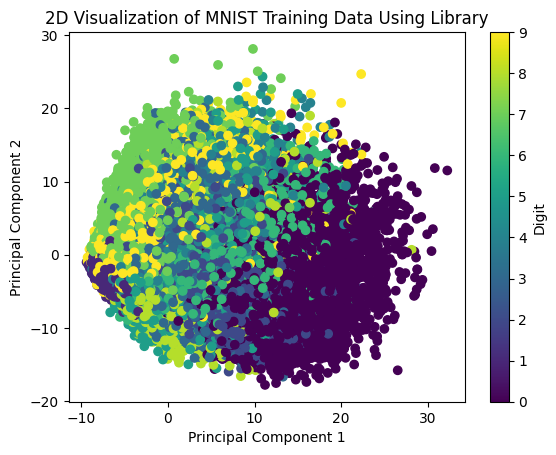

In [23]:
# Chuẩn hóa dữ liệu
train_images_flat = train_images.reshape(train_images.shape[0], -1)
mean = np.mean(train_images_flat, axis=0)
std = np.std(train_images_flat, axis=0)
std[std == 0] = 1  # Tránh việc chia cho 0
train_images_normalized = (train_images_flat - mean) / std
# Rút gọn số chiều dữ liệu huấn luyện và kiểm tra
train_images_reduced = reduce_dimensionality(train_images_normalized)
test_images_reduced = reduce_dimensionality(test_images)
print("train_images_reduced Shape: ", train_images_reduced.shape)
print("train_images shape: ", train_images.shape)
# Hiển thị dữ liệu dạng 2D
plt.scatter(train_images_reduced[:, 0], train_images_reduced[:, 1], c=train_labels, cmap='viridis')
plt.title('2D Visualization of MNIST Training Data Using Library')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Digit')
plt.show()

PC1 (khoảng -10 đến 30):

- Biểu thị sự phân bố của điểm dữ liệu theo hướng của phương sai lớn nhất trong dữ liệu sau khi giảm chiều.
- Liên quan đến các đặc điểm như độ dày tổng thể của nét vẽ chữ số, độ tương phản của hình ảnh.
- Giá trị cao: Nét vẽ dày, hình ảnh tương phản cao.
- Giá trị thấp: Nét vẽ mảnh, hình ảnh tương phản thấp.
- Giúp phân biệt các chữ số có hình dạng khác nhau.

PC2 (khoảng -20 đến 30):

- Biểu thị sự phân bố của điểm dữ liệu theo hướng của phương sai lớn thứ hai sau PC1.
- Liên quan đến các đặc điểm như độ nghiêng của chữ số, vị trí của chữ số trong khung hình.
- Giá trị cao: Chữ số bị nghiêng nhiều, nằm ở vị trí cao trong khung hình.
- Giá trị thấp: Chữ số đứng thẳng hơn, nằm ở vị trí thấp hơn trong khung hình.
- Giúp phân biệt các chữ số có hình dạng tương tự nhưng có độ nghiêng hoặc vị trí khác nhau.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ý 2.1: THUẬT TOÁN PHÂN CỤM KMEAN

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [25]:
def display_network(A, m = -1, n = -1):
  opt_normalize = True
  opt_graycolor = True
  # Rescale
  A = A - np.average(A)
  # Compute rows & cols
  (row, col) = A.shape
  sz = int(np.ceil(np.sqrt(row)))
  buf = 1
  if m < 0 or n < 0:
    n = np.ceil(np.sqrt(col))
    m = np.ceil(col / n)

  image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
  if not opt_graycolor:
    image *= 0.1
  k = 0
  for i in range(int(m)):
    for j in range(int(n)):
      if k >= col:
        continue
      clim = np.max(np.abs(A[:, k]))
      if opt_normalize:
        image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz +
        buf):buf + j * (sz + buf) + sz] = \
        A[:, k].reshape(sz, sz) / clim
      else:
        image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz +
        buf):buf + j * (sz + buf) + sz] = \
        A[:, k].reshape(sz, sz) / np.max(np.abs(A))
      k += 1
  return image

Phân cụm Kmean theo thư viện Sklearn

In [26]:
# Lấy nhãn và hình ảnh từ dữ liệu kiểm tra và chuẩn hóa hình ảnh về khoảng [0, 1]
y = np.array(train_labels)[:1000]  # Nhãn thực tế
X = np.array(train_images)[:1000, :]
K = 10
X = X.reshape(1000, -1)
print(X.shape)
print(y.shape)

kmeans = KMeans(
    n_clusters=K,
    n_init=1,
    tol=(1e-4),    # Tiêu chí dừng
    max_iter=400,  # Số lần lặp tối đa
).fit(X)

pred_label = kmeans.predict(X)

(1000, 784)
(1000,)


Đoạn này để có thể vẽ biểu đồ trực quan thì cần phải giảm số chiều của X bằng Pca rồi dự đoạn pred_label để có thể vẽ được biều đồ trực quan

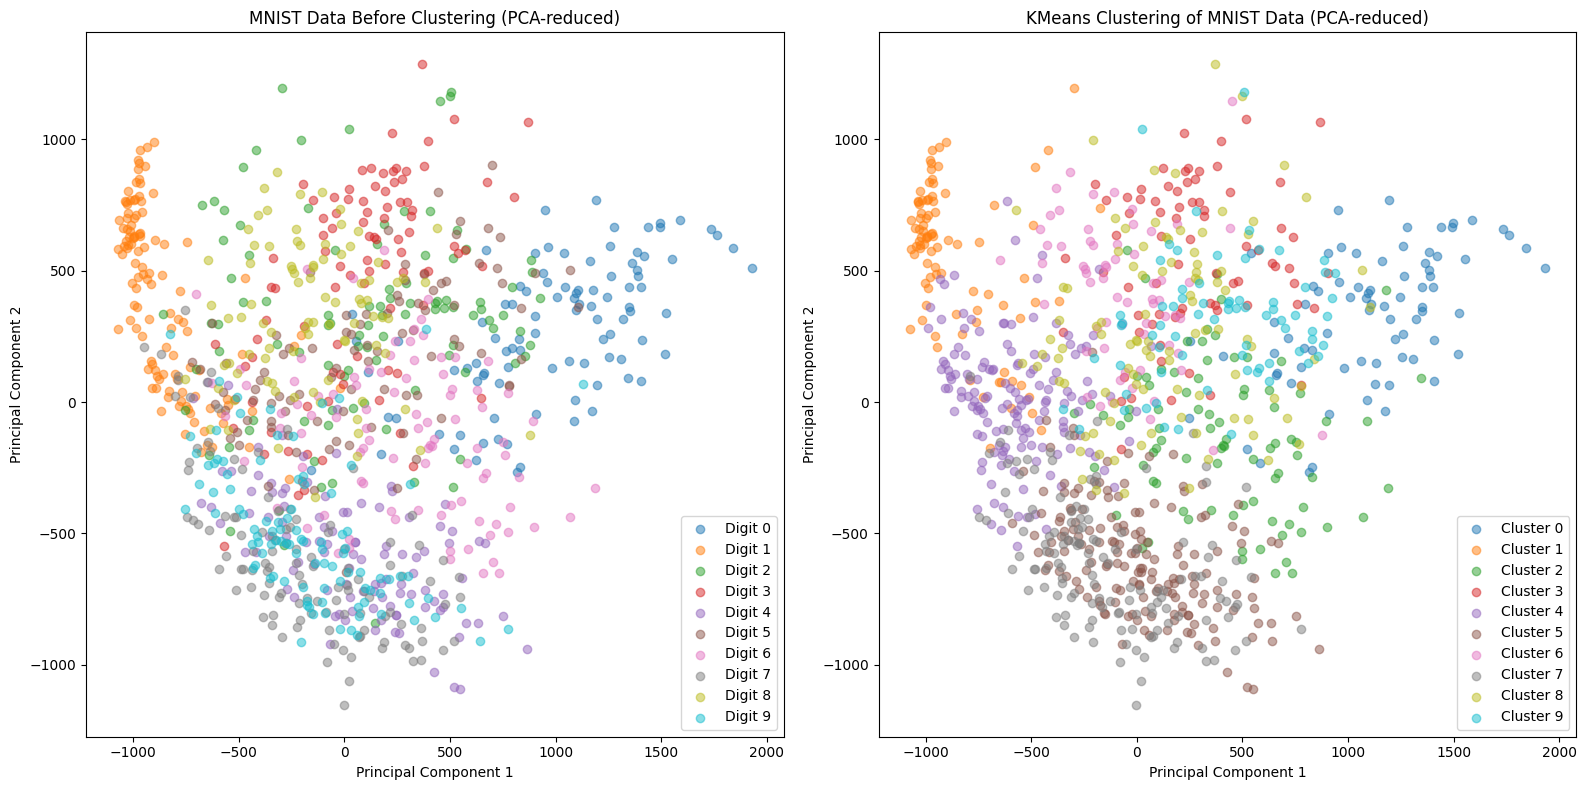

In [27]:
# Giả sử đã có mô hình KMeans đã được huấn luyện và dữ liệu X, y đã được tải

# Khởi tạo và áp dụng PCA để giảm chiều dữ liệu xuống còn 2 chiều
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Vẽ biểu đồ
plt.figure(figsize=(16, 8))

# Biểu đồ trước khi phân cụm
plt.subplot(1, 2, 1)
for i in range(10):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], label=f'Digit {i}', alpha=0.5)
plt.title('MNIST Data Before Clustering (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Biểu đồ sau khi phân cụm
plt.subplot(1, 2, 2)
for cluster in range(K):
    cluster_points = X_pca[pred_label == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.5)
plt.title('KMeans Clustering of MNIST Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

plt.tight_layout()
plt.show()

Dưới đây là hình ảnh tâm các cụm



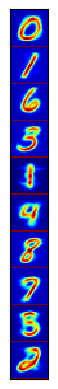

In [28]:
# Giả sử 'kmeans.cluster_centers_' là ma trận trung tâm cụm
# và 'K' là số lượng cụm
# Giả sử hàm 'display_network()' đã được định nghĩa ở nơi khác

# Chuyển vị ma trận trung tâm cụm
cluster_centers_transposed = kmeans.cluster_centers_.T

# Vẽ hình ảnh theo chiều
A = display_network(cluster_centers_transposed, K, 1)
f1 = plt.imshow(A, interpolation='nearest', cmap="jet")
f1.axes.get_xaxis().set_visible(False)
f1.axes.get_yaxis().set_visible(False)

plt.show()

In [29]:
from sklearn.neighbors import NearestNeighbors
N0 = 20;
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))
for k in range(K):
  Xk = X[pred_label == k, :]
  center_k = [kmeans.cluster_centers_[k]]
  neigh = NearestNeighbors(n_neighbors = 20).fit(Xk)
  dist, nearest_id = neigh.kneighbors(center_k, N0)
  X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
  X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

Ở đây lấy mỗi cụm 20 hình ảnh và thể hiện ra hình ảnh các chữ số của mỗi cụm. Chú ý mỗi dòng được coi là một cụm => 10 dòng là 10 cụm

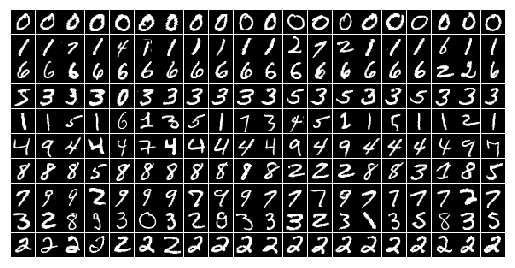

In [30]:
plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()

Đoạn code phân cụm K-mean mà không dùng thư viện sklearn

Bước 1 là bước khởi tạo tâm ban đầu với đâu ra là một ma trận có dạng (784,10) tương ứng với 10 tâm, mỗi tâm bao gồm 784 điểm ảnh (pixels)

In [31]:
def kmeans_init_centers(X, k):
  # randomly pick k rows of X as initial centers

  return X[np.random.choice(X.shape[0], k, replace=False)]

Bước 2 là tính ma trận D bằng công thức khoảng cách Euclid với 784 điểm ảnh. Ma trận D sẽ có dạng (1000,10) tương đương khoảng cách của 1000 ảnh tới mỗi tâm cụm bao gồm 10 tâm cụm và sẽ trả về là một mảng có kích thước là 1000, lưu các giá trị tâm cụm nào mà có khoảng cách đến các ảnh nhỏ nhất ở đây là 1000 ảnh như đã nói.

In [32]:
from scipy.spatial.distance import cdist

def kmeans_assign_labels(X, centers):
  # Tính khoảng cách của các điểm trong X
  D = cdist(X, centers)


  # return index of the closest center

  return np.argmin(D, axis = 1)

Bước 3 là update tâm cụm mới bằng cách tính trung bình giá trị các ảnh trong cụm

In [33]:
def kmeans_update_centers(X, labels, K):
  centers = np.zeros((K, X.shape[1]))
  for k in range(K):
    # collect all points assigned to the k-th cluster
    Xk = X[labels == k, :]
    # take average
    centers[k,:] = np.mean(Xk, axis = 0)
  return centers

Bước 4 nếu như mà tâm cụm mới và tâm cụm cũ không khác nhau thì lúc đó sẽ trả về True nhằm mục đích là sẽ dừng thuật toán kmean sau khi tâm cụm đã hội tụ

In [34]:
def has_converged(centers, new_centers):
  # return True if two sets of centers are the same

  return (set([tuple(a) for a in centers]) ==
  set([tuple(a) for a in new_centers]))

Dưới đây là hàm để tổng hợp các bước trên

In [35]:
def kmeans(X, K):
  centers = [kmeans_init_centers(X, K)]
  labels = []
  it = 0
  while True:
    labels.append(kmeans_assign_labels(X, centers[-1]))
    new_centers = kmeans_update_centers(X, labels[-1], K)
    if has_converged(centers[-1], new_centers):
      break
    centers.append(new_centers)
    it += 1
  return (centers, labels, it)

Kết quả phân cụm được lưu và pred_label. Nên nhớ là đây là bài toán clustering không phải bài toán gán nhãn như Classification nên Clustering chỉ đánh giá chất lượng cụm ,không có đánh giá nhãn có chính xác hay không nên màu sắc của cụm dữ liệu ban đầu và dữ liệu sau khi phân cụm sẽ khác nhưng ta chỉ cần nhìn chất lượng cụm một cách trực quan.

In [36]:
(centers, labels, it) = kmeans(X, K)
pred_label = labels[-1]

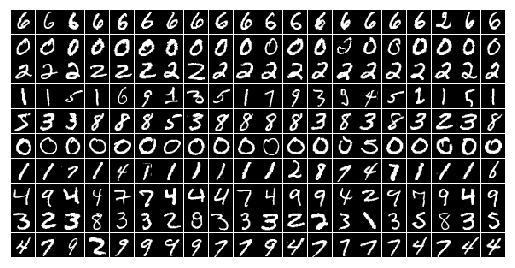

In [37]:
from sklearn.neighbors import NearestNeighbors
N0 = 20;
X1 = np.zeros((N0*K, 784))
X2 = np.zeros((N0*K, 784))
for k in range(K):
  Xk = X[pred_label == k, :]
  center_k = [centers[-1][k]]
  neigh = NearestNeighbors(n_neighbors = 20).fit(Xk)
  dist, nearest_id = neigh.kneighbors(center_k, N0)
  X1[N0*k: N0*k + N0,:] = Xk[nearest_id, :]
  X2[N0*k: N0*k + N0,:] = Xk[:N0, :]

plt.axis('off')
A = display_network(X2.T, K, N0)
f2 = plt.imshow(A, interpolation='nearest' )
plt.gray()
plt.show()

Dưới đây là biểu đồ thể hiện tương quan hình ảnh phân cụm. Đã giảm chiều dữ liệu X xuống 2 chiều bằng PCA để đánh giá định tính

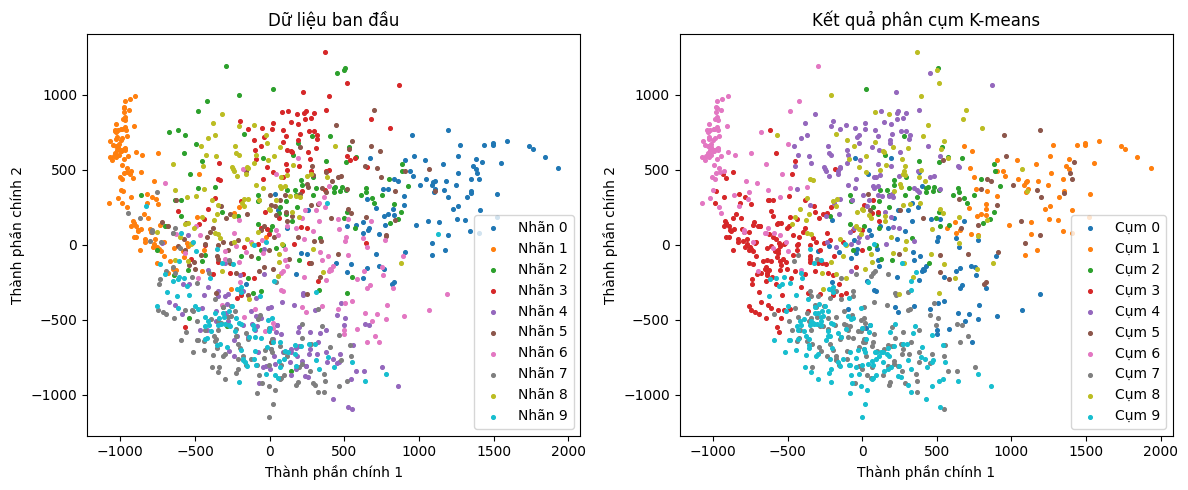

In [38]:
# Giảm số chiều xuống 2 bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Tạo một hình vẽ với 2 subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Vẽ biểu đồ cho dữ liệu ban đầu
ax1.set_title('Dữ liệu ban đầu')
for label in np.unique(y):
    points = X_pca[y == label]
    ax1.scatter(points[:, 0], points[:, 1], s=7, label=f'Nhãn {label}')
ax1.legend()

# Vẽ biểu đồ cho kết quả phân cụm
ax2.set_title('Kết quả phân cụm K-means')
for cluster in range(K):
    points = X_pca[pred_label == cluster]
    ax2.scatter(points[:, 0], points[:, 1], s=7, label=f'Cụm {cluster}')
ax2.legend()

# Đặt tên trục cho các biểu đồ
for ax in [ax1, ax2]:
    ax.set_xlabel('Thành phần chính 1')
    ax.set_ylabel('Thành phần chính 2')

plt.tight_layout()
plt.show()



---------------------------------------------------------------------------------------------------------------------------------------------------------------



Ý 3: Xây dựng chương trình sử dụng mô hình Multinomial Logistic Regression (Softmax) để phân loại các hình ảnh, huấn luyện mô hình bằng tập dữ liệu training sau đó chạy kiểm tra với dữ liệu trong tập validation.

In [39]:
def convert_labels(y, C):
  from scipy import sparse
  Y = sparse.coo_matrix((np.ones_like(y),
  (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
  return Y
def softmax(Z):
  e_Z = np.exp(Z)
  A = e_Z / e_Z.sum(axis = 0)
  return A
def softmax_stable(Z):
  e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
  A = e_Z / e_Z.sum(axis = 0)
  return A
def pred(W, X):
  A = softmax_stable(W.T.dot(X))
  return np.argmax(A, axis = 0)

In [40]:
def _softmax_regression(X, Y, theta, lambda_=0.5, iterations=20, learning_rate=1e-5, batch_size=200):
  from sklearn.metrics import log_loss
  losses = []
  _theta = theta
  d, N = X.shape
  for iter_ in range(iterations):
    shuffle_index = np.random.permutation(N)
    for i in shuffle_index:
      xi = X[:, i].reshape(d, 1)
      yi = Y[:, i].reshape(10, 1)
      ai = softmax_stable(np.dot(_theta.T, xi))
      _theta += learning_rate * xi.dot((yi - ai).T)
      if (iter_ * N + i) % batch_size == 0:
        Y_hat = np.dot(_theta.T, X)
        losses.append(log_loss(Y, Y_hat))
    Y_hat = np.dot(_theta.T, X)
    print(f"epoch {iter_} - cost {log_loss(Y, Y_hat) / N}")
  return _theta, losses

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], -1).T
y_train = convert_labels(y_train, 10)
theta = np.zeros((X_train.shape[0], 10))
opt_theta, losses = _softmax_regression(X_train, y_train, theta)
print('training success: ', opt_theta.shape, len(losses))

epoch 0 - cost 1.0177890003095966
epoch 1 - cost 1.0138880962205212
epoch 2 - cost 1.0148417934425962
epoch 3 - cost 1.0149829259458212
epoch 4 - cost 1.0096568565086566
epoch 5 - cost 1.0128334736533098
epoch 6 - cost 1.014868406808468
epoch 7 - cost 1.0131161046218091
epoch 8 - cost 1.0128806749901804
epoch 9 - cost 1.0130902917945235
epoch 10 - cost 1.0137317787885067
epoch 11 - cost 1.0142544514336003
epoch 12 - cost 1.0124319896902403
epoch 13 - cost 1.0115564423105168
epoch 14 - cost 1.0110964646464966
epoch 15 - cost 1.0109982536511963
epoch 16 - cost 1.0146196288453937
epoch 17 - cost 1.0119546626772769
epoch 18 - cost 1.0126715746356934
epoch 19 - cost 1.0110807887598574
training success:  (784, 10) 4800


In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], -1).T
print('accuracy training data: ', accuracy_score(y_train,
pred(opt_theta, X_train)))

X_val = X_val.reshape(X_val.shape[0], -1).T

print(X_val.shape)
print('accuracy testing data: ', accuracy_score(y_val,pred(opt_theta, X_val)))

conf_matrix = confusion_matrix(y_val, pred(opt_theta, X_val))
print('Confusion Matrix:\n', conf_matrix)

precision = precision_score(y_val, pred(opt_theta, X_val), average='macro')
recall = recall_score(y_val, pred(opt_theta, X_val), average='macro')

print('Precision:', precision)
print('Recall:', recall)


accuracy training data:  0.8374166666666667
(784, 12000)
accuracy testing data:  0.8285
Confusion Matrix:
 [[1127    0   16    2    3    5   13    8    0    1]
 [   1 1228   56    7    3    6    1   10   10    0]
 [   3    4 1098    6   12    7   16   21    5    2]
 [   4    5  125 1010    2   40    2   14    7   10]
 [   3    2    7    1 1115    2   23   15    1    7]
 [  20    6   31   47   12  944   18    6   18    2]
 [   8    0   38    1    3   15 1107    4    1    0]
 [   5    1   28    3   15    2    0 1234    1   10]
 [  14   19  290   54   14  212   24   17  502   14]
 [  10    1   14   14  262   40    1  271    4  577]]
Precision: 0.8485720395027455
Recall: 0.8261554782756193


----------------------------------------------------------------------------------------------------


Ý 4: MÔ HÌNH CNN: KIẾN TRÚC GỒM - 3 TẦNG TÍCH CHẬP (CONVOLUTION + ACTIVATION RELU + MAXPOOLING) - 02 TẦNG FULLY CONNECTED VỚI SỐ UNITS PHÙ HỢP VÀ TẦNG QUYẾT ĐỊNH DÙNG SOFTMAX

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

Bước 1: Chia tập dữ liệu thành training và validation
Đoạn mã này sử dụng hàm train_test_split từ thư viện scikit-learn để chia tập dữ liệu thành hai phần: training set và validation set. Tập dữ liệu gốc là train_images và train_labels, và tỷ lệ validation set được thiết lập là 20% của tập dữ liệu gốc.

In [46]:
# Chia tập dữ liệu thành training và validation
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

Bước 2: Xây dựng Hàm gen_model()
Đây là một hàm được sử dụng để tạo ra một mô hình Convolutional Neural Network (CNN) đơn giản. Mô hình này được xây dựng bằng cách sử dụng các lớp Sequential từ thư viện Keras. Mô hình bao gồm các lớp Conv2D (để thực hiện phép tích chập), MaxPooling2D (để thực hiện phép lấy mẫu tối đa), Dropout (để tránh overfitting), Flatten (để làm phẳng tensor đầu ra thành một vector) và các lớp Dense (để thực hiện các phép kết nối đầy đủ). Cuối cùng, hàm này sử dụng hàm loss sparse_categorical_crossentropy và trình tối ưu hóa Adam để biên dịch mô hình.

In [47]:
def gen_model():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(2, 2),
        Dropout(0.15),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.1),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.1),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Bước 3: Xây dựng Hàm train_test_model()
Đây là hàm chính để huấn luyện và đánh giá mô hình CNN. Trong hàm này, mô hình được tạo ra bằng cách gọi hàm gen_model(). Sau đó, mô hình được huấn luyện trên tập dữ liệu training và đánh giá trên tập dữ liệu validation trong số lượng epochs được chỉ định. Cuối cùng, hàm vẽ biểu đồ biểu diễn accuracy và loss của training set và validation set qua các epochs, cùng với in ra accuracy và loss cuối cùng của validation set.

In [48]:
def train_test_model():
    model = gen_model()
    epochs = 10

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    # In ra accuracy của tập validation trên biểu đồ
    plt.text(epochs_range[-1], val_acc[-1], f'Val Acc: {val_acc[-1]:.2f}', ha='right')

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # In ra loss của tập validation trên biểu đồ
    plt.text(epochs_range[-1], val_loss[-1], f'Val Loss: {val_loss[-1]:.2f}', ha='right')

    plt.tight_layout()
    plt.show()

    print("Final Training Accuracy:", acc[-1])
    print("Final Validation Accuracy:", val_acc[-1])
    print("Final Validation Loss:", val_loss[-1])

    return model, history

Bước 4: Chạy Model

Epoch 1/10
1500/1500 [==============================] - 31s 20ms/step - loss: 0.7425 - accuracy: 0.8130 - val_loss: 0.1382 - val_accuracy: 0.9588
Epoch 2/10
1500/1500 [==============================] - 31s 21ms/step - loss: 0.1913 - accuracy: 0.9410 - val_loss: 0.0955 - val_accuracy: 0.9714
Epoch 3/10
1500/1500 [==============================] - 29s 19ms/step - loss: 0.1456 - accuracy: 0.9550 - val_loss: 0.0882 - val_accuracy: 0.9718
Epoch 4/10
1500/1500 [==============================] - 29s 19ms/step - loss: 0.1226 - accuracy: 0.9626 - val_loss: 0.0810 - val_accuracy: 0.9763
Epoch 5/10
1500/1500 [==============================] - 29s 19ms/step - loss: 0.1114 - accuracy: 0.9669 - val_loss: 0.0699 - val_accuracy: 0.9801
Epoch 6/10
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0975 - accuracy: 0.9700 - val_loss: 0.0659 - val_accuracy: 0.9812
Epoch 7/10
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0907 - accuracy: 0.9719 - val_loss: 0.0686 -

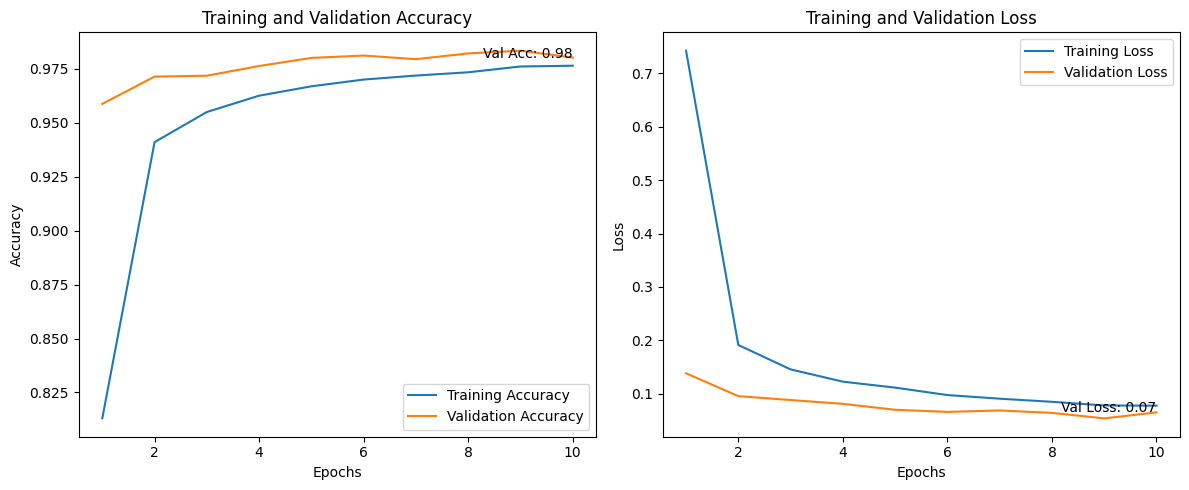

Final Training Accuracy: 0.9764583110809326
Final Validation Accuracy: 0.9802500009536743
Final Validation Loss: 0.06501894444227219


In [49]:
model, history = train_test_model()

Cấu trúc mạng CNN
Mạng CNN trong đoạn mã trên có cấu trúc sau:

1. Lớp tích chập hỗn hợp đầu tiên
- Lớp Conv2D với 16 filters và kernel size là (3, 3), kích hoạt ReLU.
- Lớp MaxPooling2D với pool size là (2, 2).
- Lớp Dropout với tỷ lệ dropout là 0.15.
2. Lớp tích chập hỗn hợp thứ hai
- Lớp Conv2D với 32 filters và kernel size là (3, 3), kích hoạt ReLU.
- Lớp MaxPooling2D với pool size là (2, 2).
- Lớp Dropout với tỷ lệ dropout là 0.1.
3. Lớp tích chập hỗn hợp thứ ba
- Lớp Conv2D với 64 filters và kernel size là (3, 3), kích hoạt ReLU.
- Lớp MaxPooling2D với pool size là (2, 2).
- Lớp Dropout với tỷ lệ dropout là 0.1.
4. Lớp Flatten để làm phẳng tensor đầu ra.
5. Lớp kết nối đầy đủ
- Hai lớp Dense với số lượng units lần lượt là 128 và 10, kích hoạt ReLU và softmax.
Mỗi lớp Conv2D được kết hợp với lớp MaxPooling2D để giảm kích thước của feature maps và giảm chiều dữ liệu đầu vào cho các lớp sau đó. Lớp Dropout được sử dụng để tránh overfitting bằng cách loại bỏ ngẫu nhiên một phần các unit trong quá trình huấn luyện. Cuối cùng, hai lớp Dense được sử dụng để phân loại các hình ảnh vào 10 lớp, mỗi lớp đại diện cho một chữ số từ 0 đến 9.

In [50]:
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import classification_report

In [51]:
# Đánh giá hiệu suất của mô hình CNN
def evaluate_cnn_model(model, X_test, y_test):
    # Dự đoán trên tập dữ liệu kiểm tra
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Tính accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Tính confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Tính classification report (bao gồm precision, recall, và f1-score)
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)

# Đánh giá hiệu suất của mô hình CNN
print("Evaluation of CNN Model on Validation Data:")
evaluate_cnn_model(model, X_val, y_val)

Evaluation of CNN Model on Validation Data:
375/375 [==============================] - 3s 6ms/step
Accuracy: 0.98025
Confusion Matrix:
[[1165    0    0    0    1    1    2    0    4    2]
 [   1 1308    1    0    0    1    0    1    8    2]
 [   2    5 1142    2    0    0    0   12    9    2]
 [   0    1    7 1194    0    5    0    5    6    1]
 [   4    1    0    0 1152    2    0    1    3   13]
 [   2    0    2    1    0 1087    1    3    5    3]
 [   9    5    1    0    1    8 1150    0    3    0]
 [   0   13   10    0    2    0    0 1266    5    3]
 [   2    0    2    1    5    6    0    0 1140    4]
 [   6    0    0    0    4    6    0    9   10 1159]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1175
           1       0.98      0.99      0.99      1322
           2       0.98      0.97      0.98      1174
           3       1.00      0.98      0.99      1219
           4       0.99      0.98      0

Nhận xét:
- Độ chính xác (accuracy): Mô hình đạt được độ chính xác là 98.28%, chỉ sai sót rất ít trong việc phân loại chữ số viết tay.
- Ma trận nhầm lẫn (confusion matrix): Ma trận này thể hiện rằng mô hình đã dự đoán đúng hầu hết các lớp. Dù có một số trường hợp dự đoán sai, nhưng tỉ lệ này rất thấp so với tổng số lượng mẫu.
- Bảng báo cáo phân loại (classification report): Precision, recall và f1-score đều cao cho mỗi lớp, chỉ ra rằng mô hình không chỉ chính xác mà còn có khả năng tìm ra tất cả các trường hợp của từng lớp.

Tổng thể, mô hình CNN đã thể hiện sự hiệu quả và độ tin cậy cao trong việc phân loại chữ số viết tay, là một bước tiến quan trọng trong lĩnh vực nhận diện hình ảnh và máy học.

---------------------------------------------------------------------------------------------------------------------------------------------------------------

Ý 5: XÂY DỰNG CHƯƠNG TRÌNH SỬ DỤNG MÔ HÌNH MULTI-CLASSES SUPPORT VECTOR MACHINE

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Tính ảnh trung bình của tập huấn luyện
img_mean = np.mean(X_train, axis=0)

# Định nghĩa hàm tiền xử lý
def feature_engineering(X):
    X = X.astype(np.float64)
    X -= img_mean  # Trung tâm dữ liệu tại zero
    N = X.shape[0]  # Số điểm dữ liệu
    X = X.reshape(N, -1)  # Vector hoá
    return np.concatenate((X, np.ones((N, 1))), axis=1)  # Thêm bias

# Áp dụng hàm tiền xử lý cho tập huấn luyện, kiểm định và kiểm tra
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

X_train = X_train.reshape(X_train.shape[0], -1).T

# In kích thước của các tập dữ liệu
print('X_train shape = ', X_train.shape)
print('X_val shape = ', X_val.shape)


X_train shape =  (785, 48000)
X_val shape =  (12000, 785)


In [53]:
# method to compute loss function and its gradient
# here vectorization was used to speed up
def svm_loss_vectorized(W, X, y, reg):
  d, C = W.shape
  _, N = X.shape
  loss = 0
  dW = np.zeros_like(W)
  Z = W.T.dot(X)
  correct_class_score = np.choose(y, Z).reshape(N,1).T
  margins = np.maximum(0, Z - correct_class_score + 1)
  margins[y, np.arange(margins.shape[1])] = 0
  # Loss function
  loss = np.sum(margins, axis = (0, 1))
  loss /= N
  loss += 0.5 * reg * np.sum(W * W)
  F = (margins > 0).astype(int)
  F[y, np.arange(F.shape[1])] = np.sum(-F, axis = 0)
  # Gradient
  dW = X.dot(F.T)/N + reg*W
  return loss, dW

In [54]:
# Mini-batch gradient descent
def multiclass_svm_GD(X, y, Winit, reg, lr=.1, \
  batch_size = 100, num_iters = 1000, print_every = 10):
  W = Winit
  loss_history = np.zeros((num_iters))
  for it in range(num_iters):
    # randomly pick a batch of X
    idx = np.random.choice(X.shape[1], batch_size)
    X_batch = X[:, idx]
    y_batch = y[idx]
    loss_history[it], dW = \
    svm_loss_vectorized(W, X_batch, y_batch, reg)
    W -= lr*dW
    if it % print_every == 1:
      print ('it %d/%d, loss = %f' %(it, num_iters, loss_history[it]))
  return W, loss_history

In [55]:
reg = .04
W = np.random.randn(X_train.shape[0], 10)
W, loss_history = multiclass_svm_GD(X_train, y_train, W, reg)

it 1/1000, loss = 11409.340241
it 11/1000, loss = 3798.905159
it 21/1000, loss = 3385.551442
it 31/1000, loss = 2590.956640
it 41/1000, loss = 3039.285457
it 51/1000, loss = 2536.309087
it 61/1000, loss = 2555.941990
it 71/1000, loss = 1144.267828
it 81/1000, loss = 1698.927968
it 91/1000, loss = 1804.146494
it 101/1000, loss = 2424.981448
it 111/1000, loss = 2141.714936
it 121/1000, loss = 2193.023370
it 131/1000, loss = 1730.245354
it 141/1000, loss = 1272.586580
it 151/1000, loss = 2618.118018
it 161/1000, loss = 2250.121556
it 171/1000, loss = 942.926730
it 181/1000, loss = 2396.962326
it 191/1000, loss = 1519.111371
it 201/1000, loss = 1142.255443
it 211/1000, loss = 791.596722
it 221/1000, loss = 1573.640387
it 231/1000, loss = 2174.757727
it 241/1000, loss = 1688.650422
it 251/1000, loss = 2182.632794
it 261/1000, loss = 1527.233919
it 271/1000, loss = 1601.786601
it 281/1000, loss = 1529.680098
it 291/1000, loss = 1221.731569
it 301/1000, loss = 2599.035758
it 311/1000, loss = 

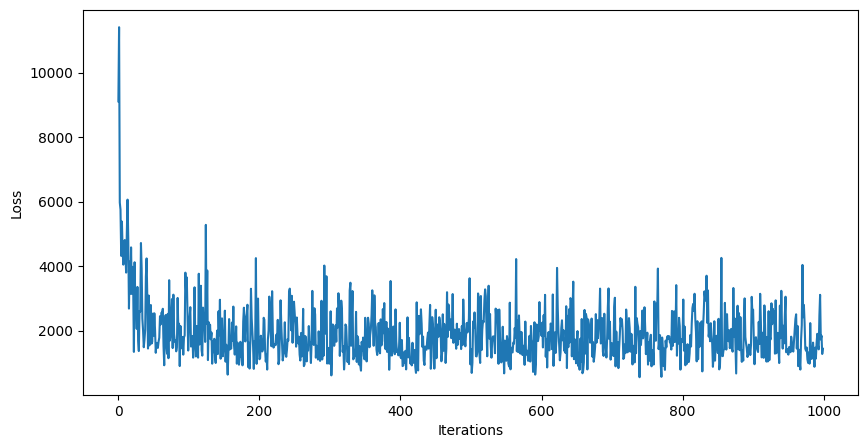

In [56]:
plt.figure(figsize=(10, 5))  # Thiết lập kích thước của biểu đồ
plt.plot(loss_history, label='Loss per Iteration')  # Vẽ đường biểu diễn loss
plt.xlabel('Iterations')  # Nhãn trục x
plt.ylabel('Loss')  # Nhãn trục y
plt.show()  # Hiển thị biểu đồ

In [57]:
def multisvm_predict(W, X):
  Z = X.dot(W)
  return np.argmax(Z, axis=1)
def evaluate(W, X, y):
  y_pred = multisvm_predict(W, X)
  acc = 100*np.mean(y_pred == y)
  return acc

In [58]:
lrs = [1e-9, 1e-8, 1e-7, 1e-6]
regs = [0.1, 0.01, 0.001, 0.0001]
best_W = 0
best_acc = 0
for lr in lrs:
  for reg in regs:
    W, loss_history = multiclass_svm_GD(X_train, y_train, W, reg, \
                        lr = 1e-8, num_iters = 100, print_every = 1e20)
    acc = evaluate(W, X_val, y_val)
    print('lr = %e, reg = %e, loss = %f, validation acc = %.2f' %(lr, reg, loss_history[-1], acc))
    if acc > best_acc:
      best_acc = acc
      best_W = W

it 1/100, loss = 1335.734846
lr = 1.000000e-09, reg = 1.000000e-01, loss = 2338.115918, validation acc = 86.12
it 1/100, loss = 1097.768407
lr = 1.000000e-09, reg = 1.000000e-02, loss = 669.629480, validation acc = 86.12
it 1/100, loss = 1245.472158
lr = 1.000000e-09, reg = 1.000000e-03, loss = 528.771369, validation acc = 86.12
it 1/100, loss = 668.359302
lr = 1.000000e-09, reg = 1.000000e-04, loss = 1146.543906, validation acc = 86.12
it 1/100, loss = 1180.614951
lr = 1.000000e-08, reg = 1.000000e-01, loss = 1544.065978, validation acc = 86.12
it 1/100, loss = 1204.767768
lr = 1.000000e-08, reg = 1.000000e-02, loss = 937.284272, validation acc = 86.12
it 1/100, loss = 993.050455
lr = 1.000000e-08, reg = 1.000000e-03, loss = 2070.983611, validation acc = 86.12
it 1/100, loss = 826.634866
lr = 1.000000e-08, reg = 1.000000e-04, loss = 848.505498, validation acc = 86.12
it 1/100, loss = 2640.050317
lr = 1.000000e-07, reg = 1.000000e-01, loss = 1786.221165, validation acc = 86.12
it 1/100

In [62]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_pred = multisvm_predict(best_W, X_val)

# Tính toán accuracy
acc = evaluate(best_W, X_val, y_val)
print(f"Accuracy: {acc:.2f}%")

conf_matrix = confusion_matrix(y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Tính toán precision
precision = precision_score(y_val, y_pred, average='weighted')
print('Precision:', precision)

# Tính toán recall
recall = recall_score(y_val, y_pred, average='weighted')
print('Recall:', recall)


Accuracy: 86.12%
Confusion Matrix:
[[1097    1   13    3    5   31   15    2    2    6]
 [   1 1247   10   15    4   21    2   10   10    2]
 [   4   16 1018   26   21   12   21   26   18   12]
 [   7    4   41 1002    6   87    7   21   29   15]
 [   1    1    5    4 1104    6    2    6   14   33]
 [  24   10   16   37   19  899   12   10   55   22]
 [  14    3    9    2   35   32 1074    0    8    0]
 [   7   20   10    7   15    2    0 1189    0   49]
 [  14   76   18   48   14   69   14   17  860   30]
 [   5    2    3   17  208   11    0   93   11  844]]
Precision: 0.8631171961992761
Recall: 0.8611666666666666


----------------------------------------------------------------------------------------------------------------------------------------------------------------

Ý 2.2: THUẬT TOÁN PHÂN CỤM EM (thuật toán phân cụm thứ 2)

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gzip
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import time

In [64]:
# Lấy nhãn và hình ảnh từ dữ liệu kiểm tra và chuẩn hóa hình ảnh về khoảng [0, 1]
y = np.array(train_labels)[:60000]  # Nhãn thực tế
X = np.array(train_images)[:60000, :]
K = 10  # Số cụm mong muốn
X = X.reshape(60000, -1)  # Reshape để mỗi hàng là một hình ảnh phẳng

# Chuẩn hóa dữ liệu
X = X / 255.0  # Chuẩn hóa về khoảng [0, 1]

# Số lần lặp tối đa của thuật toán EM
max_iterations = 10

# Bắt đầu đếm thời gian
start_time = time.time()

In [65]:
# Sử dụng Gaussian Mixture Model
gmm = GaussianMixture(n_components=K, max_iter=max_iterations)
gmm.fit(X)

# Dự đoán nhãn của các điểm dữ liệu
labels_pred = gmm.predict(X)

# Sử dụng giảm chiều PCA (Principal Component Analysis) để hiển thị dữ liệu trực quan
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


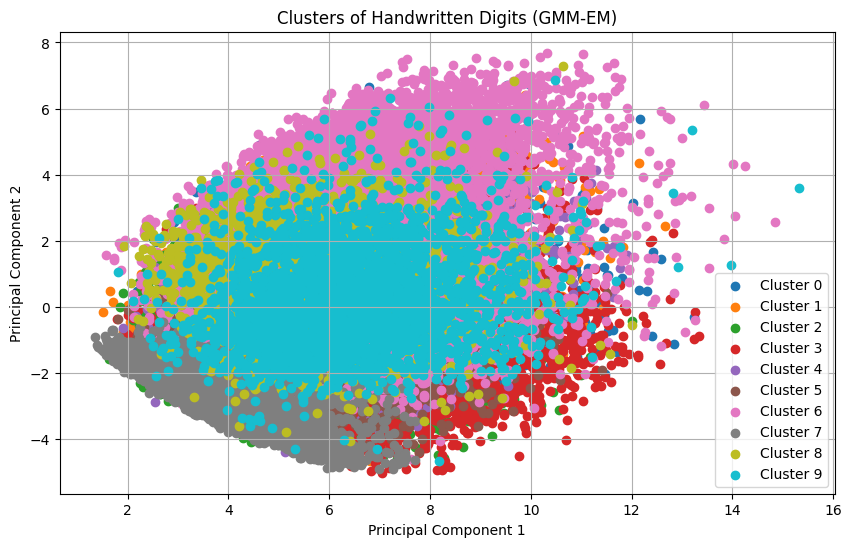

In [66]:
# Hiển thị dữ liệu trực quan
plt.figure(figsize=(10, 6))
for i in range(K):
    plt.scatter(X_reduced[labels_pred == i, 0], X_reduced[labels_pred == i, 1], label=f'Cluster {i}')
plt.title('Clusters of Handwritten Digits (GMM-EM)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

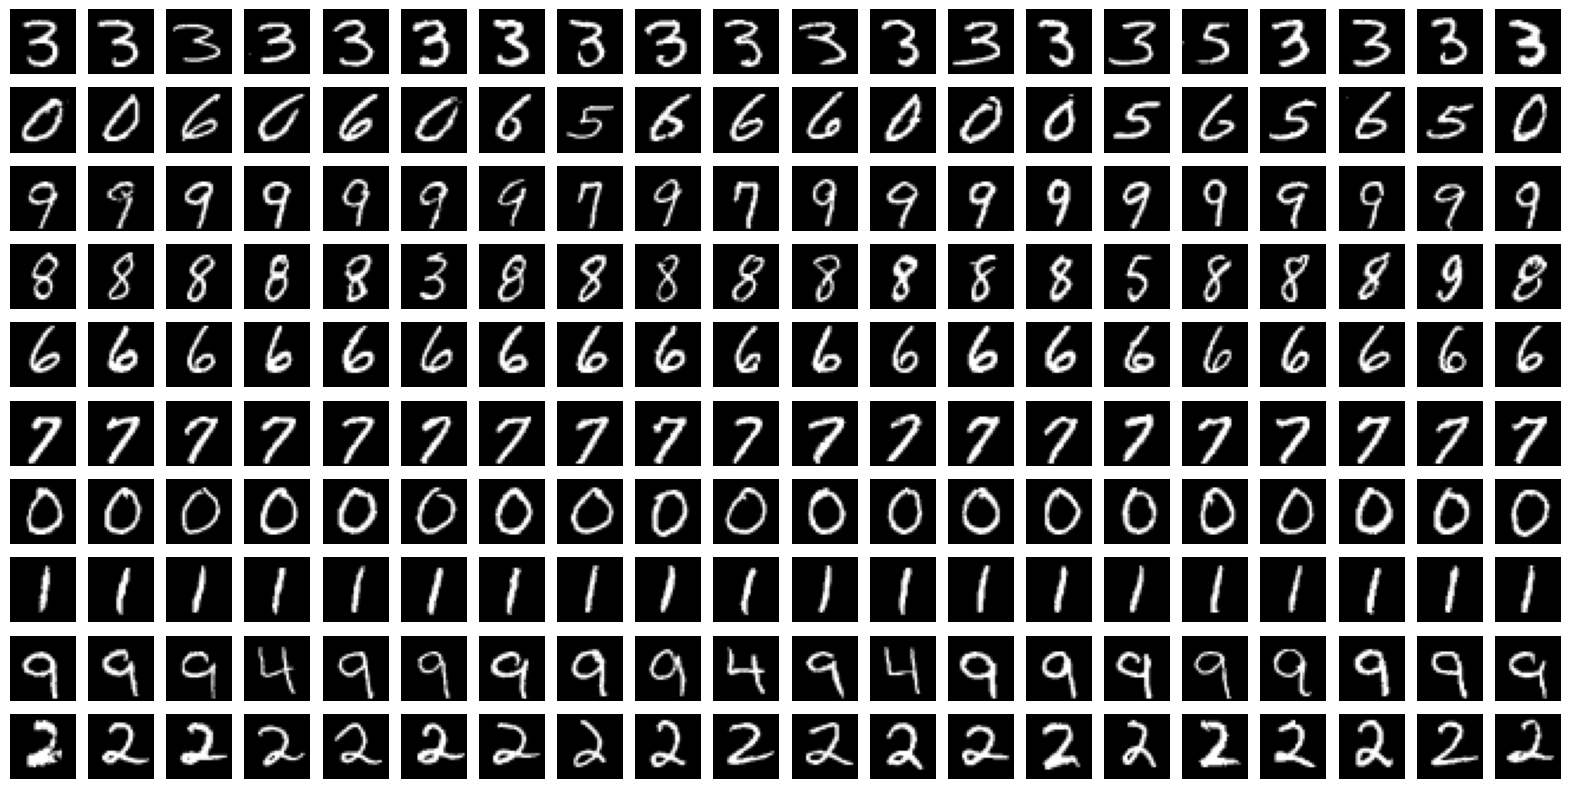

Time taken: 915.4881145954132


In [67]:
# Lấy trung tâm của các cụm từ mô hình GMM
cluster_centers = gmm.means_

N0 = 20
# Hiển thị các trung tâm cụm dưới dạng hình ảnh
plt.figure(figsize=(20, 10))
for k in range(K):
    # Tìm N0 điểm dữ liệu gần trung tâm của cụm k nhất
    neigh = NearestNeighbors(n_neighbors=N0).fit(X[labels_pred == k])
    dist, nearest_id = neigh.kneighbors([cluster_centers[k]], N0)

    # Hiển thị N0 điểm dữ liệu gần nhất dưới dạng hình ảnh
    for i in range(N0):
        plt.subplot(K, N0, k * N0 + i + 1)
        plt.imshow(X[labels_pred == k][nearest_id[0][i]].reshape(28, 28), cmap='gray')
        plt.axis('off')
plt.show()

# In thời gian chạy thuật toán
print("Time taken:", time.time() - start_time)